In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('fivethirtyeight')
from numpy.random import default_rng

# Project #02 - NYSE random walk predictor

In the [Stats and Monte Carlo](../module_02/04_Stats_and_Montecarlo) module, you created a Brownian motion model to predict the motion of particles in a fluid. The Monte Carlo model took steps in the x- and y-directions with random magnitudes. 

This [random walk](https://en.wikipedia.org/wiki/Random_walk_hypothesis) can be used to predict stock prices. Let's take a look at some data from the New York Stock Exchange [NYSE](https://www.kaggle.com/dgawlik/nyse) from 2010 through 2017. 

> __Important Note__: 
> I am not a financial advisor and these models are _purely_ for academic exercises. If you decide to use anything in these notebooks to make financial decisions, it is _at your own risk_. _I am not an economist/financial advisor/etc., I am just a Professor who likes to learn and exeriment._

Here, I will show an example workflow to analyze and predict the Google
stock price [[GOOGL]](https://en.wikipedia.org/wiki/Alphabet_Inc.) from
2010 - 2014. Then, you can choose your own stock price to evaluate and
create a predictive model.

1. Explore data and select data of interest
2. Find statistical description of data: mean and standard deviation
3. Create random variables
4. Generate random walk for [[GOOGL]](https://en.wikipedia.org/wiki/Alphabet_Inc.) stock opening price

## 1. Explore data

Here, I load the data into a Pandas dataframe to see what headings and values are available. I see two columns that I want to analyze
- 'date'
- 'open'

In [2]:
data = pd.read_csv('../data/nyse-data.csv')
data['date'] = pd.to_datetime(data['date'])
data

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
851262,2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0


I only want the `symbol == GOOGL` data, so I use a Pandas call. I also want to remove the big drop in price after Mar, 2014, so I specify the date < 2014-03-01.

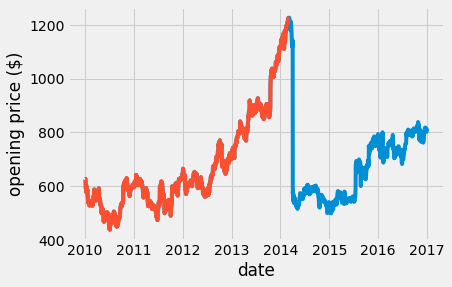

In [3]:
google_data = data[data['symbol'] == 'GOOGL']

plt.plot(google_data['date'], google_data['open'])

# remove data > 2014-03-01

google_data_pre_2014 = google_data[ google_data['date'] < pd.to_datetime('2014-03-01')]
plt.plot(google_data_pre_2014['date'], google_data_pre_2014['open'])
plt.xlabel('date')
plt.ylabel('opening price (\$)');

## 2. Data analysis

The GOOGL stock nearly doubled in price from 2010 through 2014. Day-to-day, the price fluctuates randomly. Here, I look at the fluctuations in price using [`np.diff`](https://numpy.org/doc/1.20/reference/generated/numpy.diff.html).

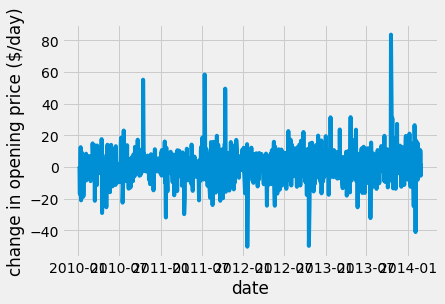

In [4]:
dprice = np.diff(google_data_pre_2014['open'])
plt.plot(google_data_pre_2014['date'][1:], dprice)
plt.xlabel('date')
plt.ylabel('change in opening price (\$/day)');

Looking at the price day-to-day, it would appear to be an average change of $0/day. Next, I explore the statistical results of the change in opening price

- mean
- standard deviation
- histogram

In [5]:
mean_dprice = np.mean(dprice)
std_dprice = np.std(dprice)
x = np.linspace(-40, 40)
from scipy import stats
price_pdf = stats.norm.pdf(x, loc = mean_dprice, scale = std_dprice)

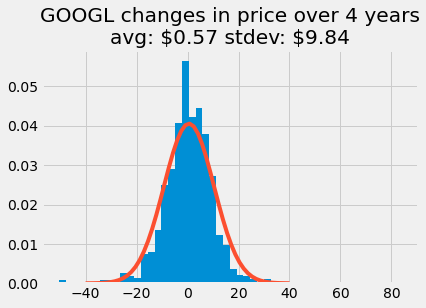

In [6]:
plt.hist(dprice, 50, density=True)
plt.plot(x, price_pdf)
plt.title('GOOGL changes in price over 4 years\n'+
         'avg: \${:.2f} stdev: \${:.2f}'.format(mean_dprice, std_dprice));

From this statistical result, it looks like the price changes followed a normal distribution with an average change of $\$0.57$ and a standard deviation of $\$9.84$.

## 3. Create random variables

Now, I know the distribution shape and characteristics to simulate the random walk price changes for the GOOGL prices each day. Here, I generate random variables with the following array structure:

Date |model 1| model 2| model 3|...| model N|
---|---|---|---|---|---|
day 1|$\Delta \$ model~1$|$\Delta \$ model~2$|$\Delta \$ model~3$|...|$\Delta \$ model~N$|
day 2|$\Delta \$ model~1$|$\Delta \$ model~2$|$\Delta \$ model~3$|...|$\Delta \$ model~N$|
...|...|...|...|...|...|

Each column is one random walk model. Each row is one simulated day. If I want to look at _one_ model predition, I would plot one column. If I want to look at the _average_ result, I take the average of each row. To start, I'll create 100 random walk models. I use the [`normal`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal) distribution to match the statistical distribution I found in part 2.

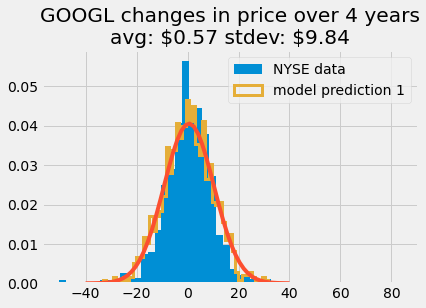

In [7]:
rng = default_rng(42)
N_models = 100
dprice_model = rng.normal(size = (len(google_data_pre_2014), N_models), loc = 0.568, scale = 9.838)

plt.hist(dprice, 50, density=True, label = 'NYSE data')
plt.plot(x, price_pdf)
plt.hist(dprice_model[:, 0], 50, density = True, 
         histtype = 'step', 
         linewidth = 3, label = 'model prediction 1')
plt.title('GOOGL changes in price over 4 years\n'+
         'avg: \${:.2f} stdev: \${:.2f}'.format(mean_dprice, std_dprice))
plt.legend();

## 4. Generate random walk predictions

Above, I show tha the simulated data follows the requested normal distribution. Now, I can cumulatively sum these steps to predict the stock prices each day. I use the  [`np.cumsum`](https://numpy.org/doc/1.20/reference/generated/numpy.cumsum.html) argument, `axis = 0` to sum along the columns i.e. each row becomes the sum of previous rows. 

```python
>>> a = np.array([[1,2,3], [4,5,6]])
>>> a
array([[1, 2, 3],
       [4, 5, 6]])
>>>> np.cumsum(a,axis=0)      # sum over rows for each of the 3 columns
array([[1, 2, 3],
       [5, 7, 9]])
```

Then, I plot all of the random walk models to compare to the NYSE data. The models are given transparency using the `alpha = 0.3` command (_`alpha = 0` is invisible, `alpha = 1` is opaque_).

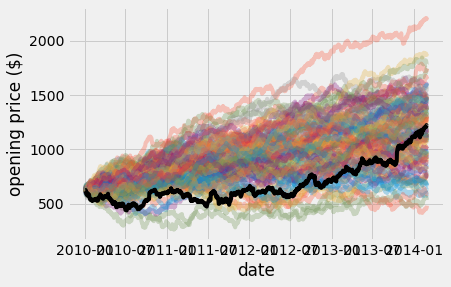

In [8]:
price_model = np.cumsum(dprice_model, axis = 0) + google_data_pre_2014['open'].values[0]

plt.plot(google_data_pre_2014['date'], price_model, alpha = 0.3);

plt.plot(google_data_pre_2014['date'], google_data_pre_2014['open'], c = 'k', label = 'NYSE data')
plt.xlabel('date')
plt.ylabel('opening price (\$)');

As you would expect, there are a wide variety of predictions for the price of GOOGL stocks using random numbers. Next, I try to get some insight into the average changes in the random walk model. I use the `np.mean` and `np.std` across the columns of the `price_model` prediction data, using `axis = 1` now.

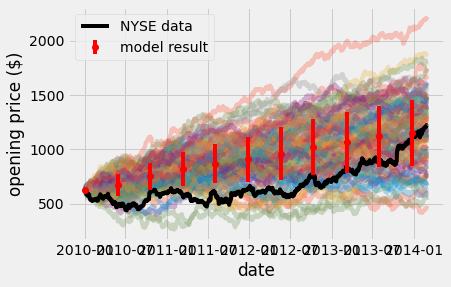

In [9]:
price_model_avg = np.mean(price_model, axis = 1)
price_model_std = np.std(price_model, axis = 1)

plt.plot(google_data_pre_2014['date'], price_model, alpha = 0.3);

plt.plot(google_data_pre_2014['date'], google_data_pre_2014['open'], c = 'k', label = 'NYSE data')
plt.xlabel('date')
plt.ylabel('opening price (\$)');

skip = 100
plt.errorbar(google_data_pre_2014['date'][::skip], price_model_avg[::skip],
             yerr = price_model_std[::skip], 
             fmt = 'o',
             c = 'r', 
             label = 'model result', 
            zorder = 3);
plt.legend();
    

## Wrapping up

In this analysis, I went through data exploration, analysis, and Monte Carlo model prediction. The average random walk should resemble a straight line. There are further insights you can get by analyzing the random walk data, but for now it looks like we can accurately predict the growth of GOOGL stock over four years. __What are some caveats to this method? If we continue to predict prices into 2015, what would happen compared to the real data?__

## Next Steps

Now, you can try your hand at predicting stock prices on your own stock. Choose your own stock symbol and go through the same 4 steps I detailed above:
1. Explore data and select _your own_ stock of interest
2. Find statistical description of data: mean and standard deviation _use some of the graphing + analysis techniques in [01_Cheers_stats_beers](../module_02/01_Cheers_Stats_Beers) and [02_Seeing_stats](02_Seeing_Stats).
3. Create random variables
4. Generate random walk for _choose your own_ stock opening price

Here are the list of stocks in this dataset:
'A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE',
       'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES', 'AET',
       'AFL', 'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK',
       'ALL', 'ALLE', 'ALXN', 'AMAT', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT',
       'AMZN', 'AN', 'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC',
       'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AYI', 'AZO', 'BA',
       'BAC', 'BAX', 'BBBY', 'BBT', 'BBY', 'BCR', 'BDX', 'BEN', 'BHI',
       'BIIB', 'BK', 'BLK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CA',
       'CAG', 'CAH', 'CAT', 'CB', 'CBG', 'CBS', 'CCI', 'CCL', 'CELG',
       'CERN', 'CF', 'CFG', 'CHD', 'CHK', 'CHRW', 'CHTR', 'CI', 'CINF',
       'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC',
       'CNP', 'COF', 'COG', 'COH', 'COL', 'COO', 'COP', 'COST', 'COTY',
       'CPB', 'CRM', 'CSCO', 'CSRA', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS',
       'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX',
       'DHI', 'DHR', 'DIS', 'DISCA', 'DISCK', 'DLPH', 'DLR', 'DLTR',
       'DNB', 'DOV', 'DOW', 'DPS', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN',
       'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR',
       'ENDP', 'EOG', 'EQIX', 'EQR', 'EQT', 'ES', 'ESRX', 'ESS', 'ETFC',
       'ETN', 'ETR', 'EVHC', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F',
       'FAST', 'FB', 'FBHS', 'FCX', 'FDX', 'FE', 'FFIV', 'FIS', 'FISV',
       'FITB', 'FL', 'FLIR', 'FLR', 'FLS', 'FMC', 'FOX', 'FOXA', 'FRT',
       'FSLR', 'FTI', 'FTR', 'FTV', 'GD', 'GE', 'GGP', 'GILD', 'GIS',
       'GLW', 'GM', 'GOOG', 'GOOGL', 'GPC', 'GPN', 'GPS', 'GRMN', 'GS',
       'GT', 'GWW', 'HAL', 'HAR', 'HAS', 'HBAN', 'HBI', 'HCA', 'HCN',
       'HCP', 'HD', 'HES', 'HIG', 'HOG', 'HOLX', 'HON', 'HP', 'HPE',
       'HPQ', 'HRB', 'HRL', 'HRS', 'HSIC', 'HST', 'HSY', 'HUM', 'IBM',
       'ICE', 'IDXX', 'IFF', 'ILMN', 'INTC', 'INTU', 'IP', 'IPG', 'IR',
       'IRM', 'ISRG', 'ITW', 'IVZ', 'JBHT', 'JCI', 'JEC', 'JNJ', 'JNPR',
       'JPM', 'JWN', 'K', 'KEY', 'KHC', 'KIM', 'KLAC', 'KMB', 'KMI',
       'KMX', 'KO', 'KORS', 'KR', 'KSS', 'KSU', 'L', 'LB', 'LEG', 'LEN',
       'LH', 'LKQ', 'LLL', 'LLTC', 'LLY', 'LMT', 'LNC', 'LNT', 'LOW',
       'LRCX', 'LUK', 'LUV', 'LVLT', 'LYB', 'M', 'MA', 'MAA', 'MAC',
       'MAR', 'MAS', 'MAT', 'MCD', 'MCHP', 'MCK', 'MCO', 'MDLZ', 'MDT',
       'MET', 'MHK', 'MJN', 'MKC', 'MLM', 'MMC', 'MMM', 'MNK', 'MNST',
       'MO', 'MON', 'MOS', 'MPC', 'MRK', 'MRO', 'MSFT', 'MSI', 'MTB',
       'MTD', 'MU', 'MUR', 'MYL', 'NAVI', 'NBL', 'NDAQ', 'NEE', 'NEM',
       'NFLX', 'NFX', 'NI', 'NKE', 'NLSN', 'NOC', 'NOV', 'NRG', 'NSC',
       'NTAP', 'NTRS', 'NUE', 'NVDA', 'NWL', 'NWS', 'NWSA', 'O', 'OKE',
       'OMC', 'ORCL', 'ORLY', 'OXY', 'PAYX', 'PBCT', 'PBI', 'PCAR', 'PCG',
       'PCLN', 'PDCO', 'PEG', 'PEP', 'PFE', 'PFG', 'PG', 'PGR', 'PH',
       'PHM', 'PKI', 'PLD', 'PM', 'PNC', 'PNR', 'PNW', 'PPG', 'PPL',
       'PRGO', 'PRU', 'PSA', 'PSX', 'PVH', 'PWR', 'PX', 'PXD', 'PYPL',
       'QCOM', 'QRVO', 'R', 'RAI', 'RCL', 'REGN', 'RF', 'RHI', 'RHT',
       'RIG', 'RL', 'ROK', 'ROP', 'ROST', 'RRC', 'RSG', 'RTN', 'SBUX',
       'SCG', 'SCHW', 'SE', 'SEE', 'SHW', 'SIG', 'SJM', 'SLB', 'SLG',
       'SNA', 'SNI', 'SO', 'SPG', 'SPGI', 'SPLS', 'SRCL', 'SRE', 'STI',
       'STT', 'STX', 'STZ', 'SWK', 'SWKS', 'SWN', 'SYF', 'SYK', 'SYMC',
       'SYY', 'T', 'TAP', 'TDC', 'TDG', 'TEL', 'TGNA', 'TGT', 'TIF',
       'TJX', 'TMK', 'TMO', 'TRIP', 'TROW', 'TRV', 'TSCO', 'TSN', 'TSO',
       'TSS', 'TWX', 'TXN', 'TXT', 'UAA', 'UAL', 'UDR', 'UHS', 'ULTA',
       'UNH', 'UNM', 'UNP', 'UPS', 'URBN', 'URI', 'USB', 'UTX', 'V',
       'VAR', 'VFC', 'VIAB', 'VLO', 'VMC', 'VNO', 'VRSK', 'VRSN', 'VRTX',
       'VTR', 'VZ', 'WAT', 'WBA', 'WDC', 'WEC', 'WFC', 'WFM', 'WHR',
       'WLTW', 'WM', 'WMB', 'WMT', 'WRK', 'WU', 'WY', 'WYN', 'WYNN',
       'XEC', 'XEL', 'XL', 'XLNX', 'XOM', 'XRAY', 'XRX', 'XYL', 'YHOO',
       'YUM', 'ZBH', 'ZION', 'ZTS'

In [10]:
symb = 'XOM'

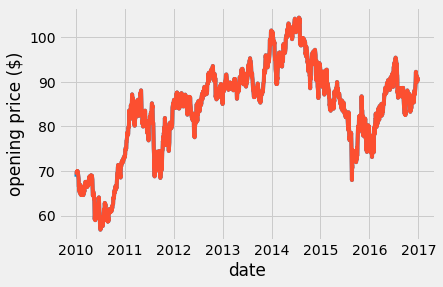

In [11]:
xom_data = data[data['symbol'] == symb]
xom_data


# slicer= [pd.to_datetime("6-1-2010"), pd.to_datetime("7-1-2014")]
# slicer= [pd.to_datetime("7-1-2014"), xom_data['date'].iat[-320]]
slicer = [ xom_data['date'].iat[0],  xom_data['date'].iat[-1]]
slicer_delta = slicer[1]-slicer[0]

xom_slice = xom_data[np.logical_and(slicer[0] < xom_data['date'], xom_data['date'] < slicer[1])]


plt.plot(xom_data['date'], xom_data['open'])
plt.plot(xom_slice['date'], xom_slice['open'])
plt.xlabel('date')
plt.ylabel('opening price (\$)');

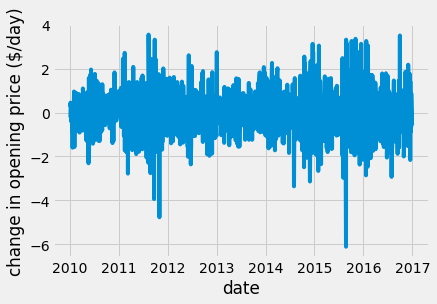

In [12]:
dprice = np.diff(xom_slice['open'])
plt.plot(xom_slice['date'][1:], dprice)
plt.xlabel('date')
plt.ylabel('change in opening price (\$/day)');

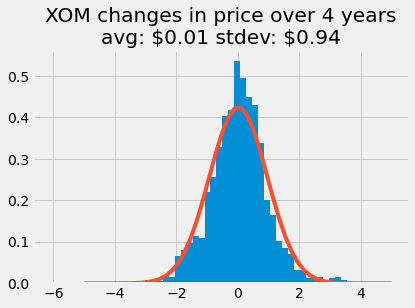

In [13]:
mean_dprice = np.mean(dprice)
std_dprice = np.std(dprice)
x = np.linspace(-5, 5)
from scipy import stats
price_pdf = stats.norm.pdf(x, loc = mean_dprice, scale = std_dprice)

plt.hist(dprice, 50, density=True)
plt.plot(x, price_pdf)
plt.title('XOM changes in price over 4 years\n'+
         'avg: \${:.2f} stdev: \${:.2f}'.format(mean_dprice, std_dprice));

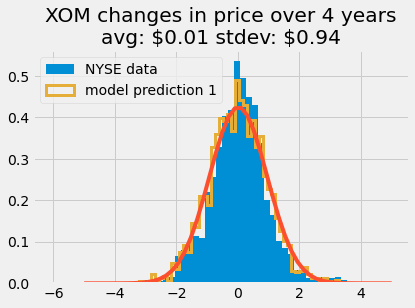

In [14]:
rng = default_rng(42)
N_models = 100
dprice_model = rng.normal(size = (len(xom_slice), N_models), loc = mean_dprice, scale = std_dprice)

plt.hist(dprice, 50, density=True, label = 'NYSE data')
plt.plot(x, price_pdf)
plt.hist(dprice_model[:, 0], 50, density = True, 
         histtype = 'step', 
         linewidth = 3, label = 'model prediction 1')
plt.title('XOM changes in price over 4 years\n'+
         'avg: \${:.2f} stdev: \${:.2f}'.format(mean_dprice, std_dprice))
plt.legend();

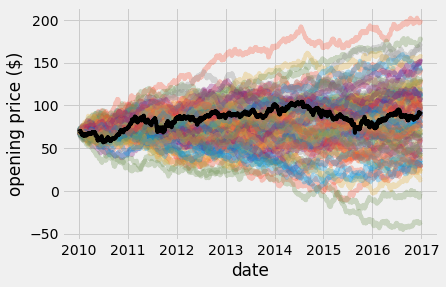

In [15]:
price_model = np.cumsum(dprice_model, axis = 0) + xom_slice['open'].values[0]

plt.plot(xom_slice['date'], price_model, alpha = 0.3);

plt.plot(xom_slice['date'], xom_slice['open'], c = 'k', label = 'NYSE data')
plt.xlabel('date')
plt.ylabel('opening price (\$)');

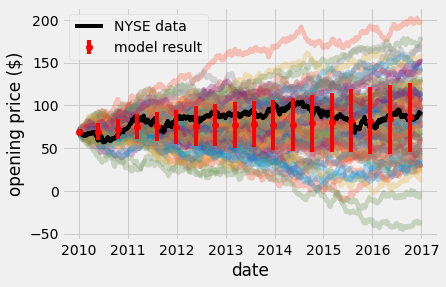

In [16]:
price_model_avg = np.mean(price_model, axis = 1)
price_model_std = np.std(price_model, axis = 1)

plt.plot(xom_slice['date'], price_model, alpha = 0.3);

plt.plot(xom_slice['date'], xom_slice['open'], c = 'k', label = 'NYSE data')
plt.xlabel('date')
plt.ylabel('opening price (\$)');

skip = 100
plt.errorbar(xom_slice['date'][::skip], price_model_avg[::skip],
             yerr = price_model_std[::skip], 
             fmt = 'o',
             c = 'r', 
             label = 'model result', 
            zorder = 3);
plt.legend();